---------------------------------------------------------------
## I. IMPORT ET PRÉPARATION
--------------------------------------------------------------

On importe d'abord l'ensemble des bibliothèques nécessaire au traitement de notre code.

In [90]:
import pandas as pd
import numpy as np
from datasets import load_dataset

import math
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

---
### 1. Import
---

In [40]:
# On se connecte à la base de données de Huggingface
ds = load_dataset("roupenminassian/twitter-misinformation")

In [41]:
# On crée un DataFrame à partir de la base de données
train = pd.DataFrame(ds["train"])
test = pd.DataFrame(ds["test"])

In [42]:
# On concatène les deux DataFrames
df = pd.concat([train, test])

In [43]:
# On affiche les 5 premières lignes du DataFrame
df.head(5)

Unnamed: 0.1  Unnamed: 0  \
0         34366       34366   
1         41656       41656   
2         26726       26726   
3         81585       81585   
4          4016        4016   

                                                text  label  
0  Local Charlotte, NC news station WSOCTV is rep...      1  
1  The tsunami has started President Obama s Keny...      1  
2  The only reality show Donald Trump should have...      1  
3  No Food, No FEMA: Hurricane Michael’s Survivor...      0  
4  WASHINGTON (Reuters) - Here are some of the hi...      0

In [44]:
# On enregistre ce DataFrame dans un fichier CSV afin de pouvoir y accéder plus tard
df.to_csv("../data/raw/df_full_source.csv", index=0)

---
### 2. Exploration préliminaire
---

#### 2.1 Analyse des répartitions et longueurs des posts

In [45]:
# On récupère le fichier CSV afin de ne pas devoir le réimporter à chaque fois
df = pd.read_csv('../data/raw/df_full_source.csv')

In [46]:
# On affiche les caractéristiques du jeu de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102661 entries, 0 to 102660
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0.1  102661 non-null  int64 
 1   Unnamed: 0    102661 non-null  int64 
 2   text          102661 non-null  object
 3   label         102661 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [47]:
df.describe()

Unnamed: 0.1    Unnamed: 0          label
count  102661.00000  102661.00000  102661.000000
mean    51330.00000   51330.00000       0.346568
std     29635.82233   29635.82233       0.475879
min         0.00000       0.00000       0.000000
25%     25665.00000   25665.00000       0.000000
50%     51330.00000   51330.00000       0.000000
75%     76995.00000   76995.00000       1.000000
max    102660.00000  102660.00000       1.000000

In [48]:
df.isna().any()

Unnamed: 0.1    False
Unnamed: 0      False
text            False
label           False
dtype: bool

Le jeu est constitué de 4 colonnes. On remarque qu'il n'y a pas de valeur manquante. Les deux premières colonnes semblent contenir les mêmes données.

In [49]:
# On renomme les colonnes pour plus de clarté.
df = df.rename(columns={"Unnamed: 0.1": "record","Unnamed: 0":"record_copy", "text": "post", "label": "fake_news"})

In [50]:
# On ajoute une colonne indiquant la longueur des posts et une autre indiquant le nombre de mots
df["post_length"] = df["post"].apply(len)
df["post_number_of_words"] = df["post"].apply(lambda x: len(x.split()))

In [51]:
# On affiche les 5 premières lignes du DataFrame
df.head(5)

record  record_copy                                               post  \
0   34366        34366  Local Charlotte, NC news station WSOCTV is rep...   
1   41656        41656  The tsunami has started President Obama s Keny...   
2   26726        26726  The only reality show Donald Trump should have...   
3   81585        81585  No Food, No FEMA: Hurricane Michael’s Survivor...   
4    4016         4016  WASHINGTON (Reuters) - Here are some of the hi...   

   fake_news  post_length  post_number_of_words  
0          1         2302                   380  
1          1         1598                   272  
2          1         2001                   360  
3          0           86                    10  
4          0         4905                   907

In [52]:
# On vérifie si les colonnes 'record' et 'record_copy' sont identiques
df['record_test'] = (df['record']-df['record_copy']).abs()

print("Nombre de valeurs différentes :", df['record_test'].sum())

Nombre de valeurs différentes : 0


Les valeurs étant les mêmes, on peut donc supprimer une des deux colonnes.

In [53]:
print("Nombre de valeurs uniques :", df['record'].nunique())

print("Tableau total théorique [0 -> 102661] : ", np.arange(0,102661, dtype=np.int64).sum())
print("Nombre de valeurs dans 'record' : ", df['record'].sum())

Nombre de valeurs uniques : 102661
Tableau total théorique [0 -> 102661] :  5269589130
Nombre de valeurs dans 'record' :  5269589130


Série de valeurs uniques, monotone de 0 à 102660, incrément = 1 : 'record' peut devenir l'index et 'record_copy' peut être éliminé.

In [57]:
# On s'intéresse à la colonne 'post' pour voir la longueur des posts
df['length_record'] = df['post']. apply(lambda x : len(str(x)))
df.head(10)

print("Nombre de caractères moyen : ", df['length_record'].mean().round(2))
print("Nombre minimum : ", df['length_record'].min())
print("Nombre maximum : ", df['length_record'].max())

Nombre de caractères moyen :  1168.19
Nombre minimum :  1
Nombre maximum :  51794


In [58]:
#Nombre de signes (caractères) par classe de longueur : < 280, <10 000, > 10 000
print("Nombre de signes au total pour tous records : ", df['length_record'].count())
print('----------------------------------------------------')
print("Nombre de signes au total records < 280 signes : ", df['length_record'].loc[df['length_record'] < 280].count())
print('----------------------------------------------------')
print("Nombre de signes au total records < 10 000 signes : ", df['length_record'].loc[df['length_record'] < 10000].count())
print('----------------------------------------------------')
print("Nombre de signes au total records >= 10 000 signes : ", df['length_record'].loc[df['length_record'] >=10000].count())

Nombre de signes au total pour tous records :  102661
----------------------------------------------------
Nombre de signes au total records < 280 signes :  55874
----------------------------------------------------
Nombre de signes au total records < 10 000 signes :  102309
----------------------------------------------------
Nombre de signes au total records >= 10 000 signes :  352


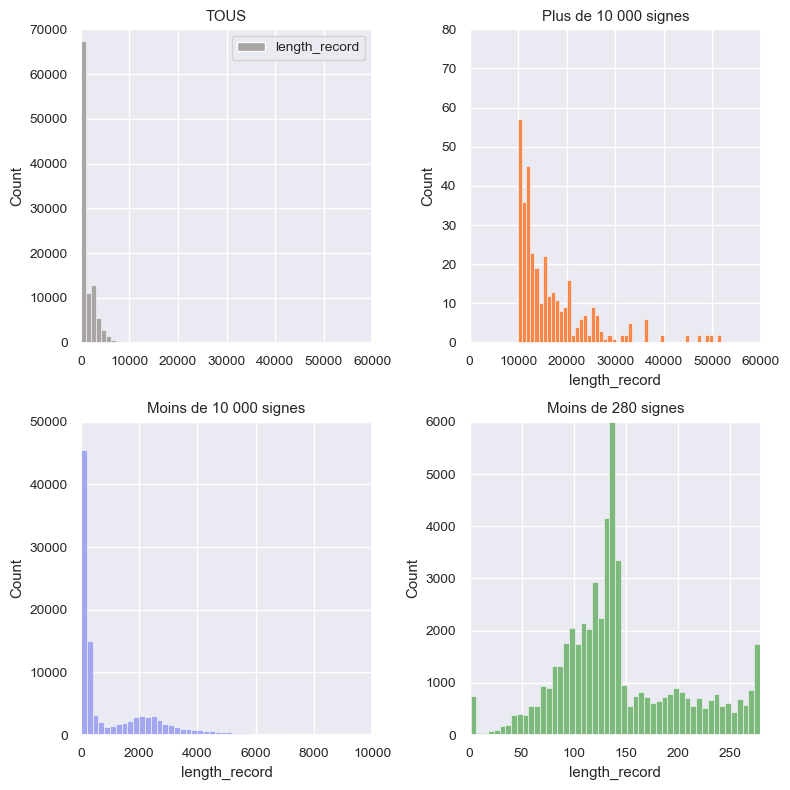

In [59]:
#NBR records par classe :

sns.set_theme(font_scale = 0.9)
fig, axes = plt.subplots(2, 2, figsize=(8,8))

# En haut à gauche : Tous
# -------------------------------------------------------------------------------------------------
sns.histplot(data=df[['length_record']], bins = 50, facecolor = '#A9A5A4', ax = axes[0,0])
axes[0, 0].set_xlim(0, 60000)
axes[0, 0].set_ylim(0, 70000) 
axes[0,0].set_title('TOUS')


# En haut à droite :>= 10 000 signes
# -------------------------------------------------------------------------------------------------
sns.histplot(data=df['length_record'].loc[df['length_record'] >=10000], bins = 50, facecolor = '#F7884D', ax = axes[0,1])
axes[0, 1].set_xlim(0, 60000)
axes[0, 1].set_ylim(0, 80) 
axes[0,1].set_title('Plus de 10 000 signes');


# En bas à gauche : < 10 000 signes
# -------------------------------------------------------------------------------------------------
sns.histplot(data=df['length_record'].loc[df['length_record'] < 10000], bins = 50, facecolor = '#A2A7F0', ax = axes[1,0])
axes[1, 0].set_xlim(0, 10000)
axes[1, 0].set_ylim(0, 50000) 
axes[1,0].set_title('Moins de 10 000 signes')


# En bas à droite : < 280 signes
# -------------------------------------------------------------------------------------------------
sns.histplot(data=df['length_record'].loc[df['length_record'] < 280], bins = 50, facecolor = '#7DB87C', ax = axes[1,1])
axes[1, 1].set_xlim(0, 280)
axes[1, 1].set_ylim(0, 6000) 
axes[1,1].set_title('Moins de 280 signes')

plt.tight_layout(pad = 1.0)
plt.show()

On constate une très forte concentration de tweet dans la tranche  100-149 caractères ce qui est logique étant donné que par défaut le nombre max de caractère est 140 sur tweeter.

In [60]:
# On affiche les posts les plus longs et les plus courts
df.loc[df['length_record'] >=10000]

record  record_copy  \
105      43831        43831   
125      31284        31284   
273      44817        44817   
598      43619        43619   
736      35361        35361   
...        ...          ...   
101378   44734        44734   
102420   43484        43484   
102424   44069        44069   
102456   43951        43951   
102660   29538        29538   

                                                     post  fake_news  \
105     J.R. Smith 21st Century WireMuch has been made...          1   
125     A speech for the ages was given today by Presi...          1   
273     By James PerloffMy friend Rachael McIntosh was...          1   
598      In response to the establishment media s cont...          1   
736     Open borders Ryan might be in for a shock when...          1   
...                                                   ...        ...   
101378   Dady Chery News Junkie Post Let me tell you a...          1   
102420  21st Century Wire says The US 2016 Presidentia...          1   
102424  Patrick Henningsen 21st Century WireAs Baron R...          1   
102456   Dady Chery News Junkie Post Let me tell you a...          1   
102660  Ted Cruz is one of the most extreme individual...          1   

        post_length  post_number_of_words  record_test  length_record  
105           12820                  2089            0          12820  
125           27468                  4547            0          27468  
273           13294                  2149            0          13294  
598           20086                  3239            0          20086  
736           10093                  1604            0          10093  
...             ...                   ...          ...            ...  
101378        11773                  1903            0          11773  
102420        12718                  1838            0          12718  
102424        14342                  2417            0          14342  
102456        11773                  1903            0          11773  
102660        17880                  3083            0          17880  

[352 rows x 8 columns]

In [61]:
df.loc[df['length_record'] < 280]

record  record_copy  \
3        81585        81585   
8        76637        76637   
12       75659        75659   
13       72525        72525   
16       53334        53334   
...        ...          ...   
102649   93881        93881   
102650  101741       101741   
102651   42077        42077   
102654   61003        61003   
102656   97099        97099   

                                                     post  fake_news  \
3       No Food, No FEMA: Hurricane Michael’s Survivor...          0   
8       His argument is correct. Hurricane Rita killed...          0   
12      im praying for all of my friends down in the C...          0   
13      To all my Texas streamers: PLEASE be safe if t...          0   
16      RT @Stacy_Spencer: There is a Tornado warning....          0   
...                                                   ...        ...   
102649  We love #CarHumor from@TheRealAutoBlog ! Flori...          0   
102650  A bogus Instagram post purports to be from an ...          1   
102651  The left keeps talking about how hateful the T...          1   
102654  @tasneamm has uni opened again? have you seen ...          0   
102656  2 new #COVID19 hydroxychloroquine trials, one ...          1   

        post_length  post_number_of_words  record_test  length_record  
3                86                    10            0             86  
8               134                    20            0            134  
12              199                    29            0            199  
13              162                    24            0            162  
16              119                    20            0            119  
...             ...                   ...          ...            ...  
102649          189                    20            0            189  
102650          273                    46            0            273  
102651          181                    32            0            181  
102654          101                    19            0            101  
102656          205                    23            0            205  

[55874 rows x 8 columns]

Nombre total de signes :  119927763
Nombre total de mots (primitive tokens) :  19426418
Moyenne de "mot primitifs" :  6.17 signes par mot, ponctuation incluse


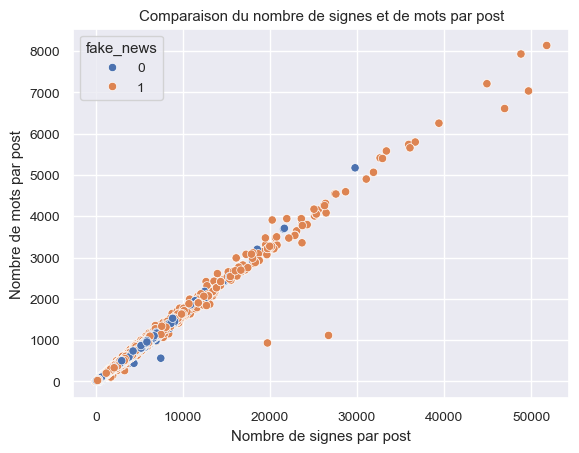

In [69]:
# WORDS (primitive tokens) VS. SIGNS : Overall 'primitive' statistic (no processing, cleaning, punctuation, lemmatization or other)

print("Nombre total de signes : ", df['post_length'].sum())
print("Nombre total de mots (primitive tokens) : ", df['post_number_of_words'].sum())
print('Moyenne de "mot primitifs" : ', (df['post_length'].sum()/df['post_number_of_words'].sum()).round(2), "signes par mot, ponctuation incluse")

#plot words vs signs
#plt.scatter(df.length_record, df.word_count)

sns.scatterplot(x = "post_length", y = "post_number_of_words", data = df, hue = 'fake_news')
plt.title("Comparaison du nombre de signes et de mots par post");
plt.xlabel("Nombre de signes par post");
plt.ylabel('Nombre de mots par post');

In [88]:
# On concatène les posts de désinformation et ceux sans désinformation pour obtenir un texte complet
text_misinformation = " ".join(tqdm(df[df['fake_news']==1]['post'],desc="Concaténation des posts de désinformation"))
text_confident = " ".join(tqdm(df[df['fake_news']==0]['post'], desc="Concaténation des posts sans désinformation"))
text_whole = text_misinformation + " " + text_confident
word_counts = Counter(text_whole)

Concaténation des posts sans désinformation: 100%|██████████| 67082/67082 [00:00<00:00, 4960285.97it/s]


In [86]:
print("Nombre de 'mots primitifs' total corpus : ", len(text_whole))
print("Nombre de 'mots primitifs uniques : ", len(word_counts))
print("Nombre d'occurences par 'mot primitif' unique : ", (len(text_whole)/len(word_counts)))
print("Occurences max :", max(list(word_counts.values())))
print("Occurences min :", min(list(word_counts.values())))

Nombre de 'mots primitifs' total corpus :  120030423
Nombre de 'mots primitifs uniques :  553
Nombre d'occurences par 'mot primitif' unique :  217053.2061482821
Occurences max : 19887217
Occurences min : 1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102661 entries, 0 to 102660
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   record                102661 non-null  int64 
 1   record_copy           102661 non-null  int64 
 2   post                  102661 non-null  object
 3   fake_news             102661 non-null  int64 
 4   post_length           102661 non-null  int64 
 5   post_number_of_words  102661 non-null  int64 
 6   record_test           102661 non-null  int64 
 7   length_record         102661 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.3+ MB


In [93]:
print(f"Le dataset contient {math.floor(df[df['post_length']<UF]['post_length'].value_counts().sum()/len(df)*100)}% de tweet dont la taille est inférieur à {math.floor(UF)} caractères")
print(f"Le dataset contient {df[df['post_number_of_words']==0].value_counts().sum()} de tweet 'vides'")
print(f"Le dataset contient {df[df['post_number_of_words']<=1].value_counts().sum()} de tweet avec un seul mot")

# Si l'on souhaite supprimer les posts dont le nombre de caractères dépasse la limite haute de la boxplot, les mots vide et les posts avec un seul mots, passez la variable à True
nettoyage=True
nb_de_tweet=len(df)
if(nettoyage):
    df = df[df['post_length'] <= UF]
    df = df[df['post_number_of_words'] != 0]
    df = df[df['post_number_of_words'] > 1]
    print(f"Il reste {len(df)} tweet (sur {nb_de_tweet} initialement) dans le jeu de données après nettoyage.")

Le dataset contient 96% de tweet dont la taille est inférieur à 4735 caractères
Le dataset contient 631 de tweet 'vides'
Le dataset contient 840 de tweet avec un seul mot
Il reste 97794 tweet (sur 102661 initialement) dans le jeu de données après nettoyage.


Il est intéressant de se pencher sur les mots les plus présents du corpus. Cela sera fait dans le notebook suivant.

#### 2.2 Analyse de la désinformation

<Figure size 300x100 with 0 Axes>

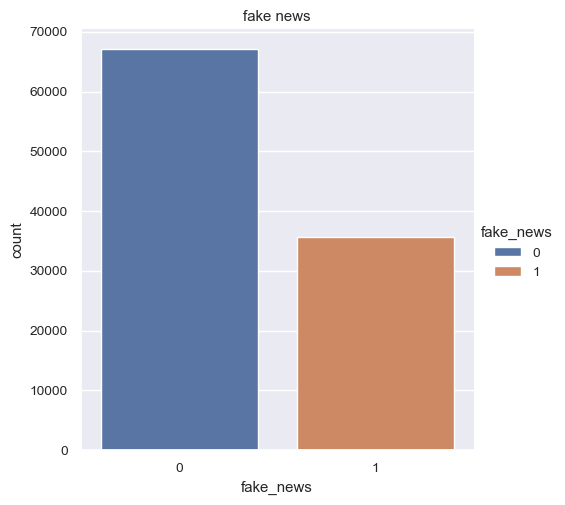

In [70]:
# nbr posts Fake news vs. non Fake News
plt.figure(figsize = (3,1))
sns.catplot(data = df, kind = 'count', x = 'fake_news', hue = 'fake_news')
plt.title('fake news');

==> Nombre moyen de mots pour les Fake News :  287.0
==> Nombre moyen de mots pour les autres :  137.0


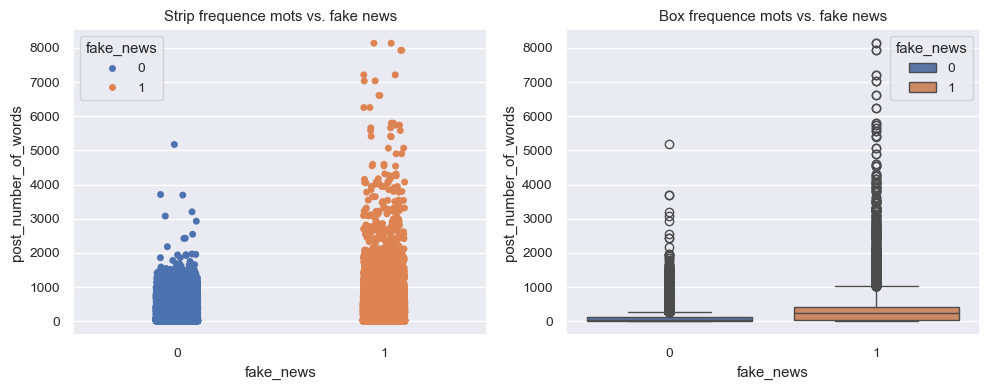

In [74]:
#------------------------------------------------------------------------------------------
# Comparaison Fake News et Real News
#--------------------------------------------------------------------------------------------

# Longueur moyenne des 2 catégories :
avg_Wcount_fake = df[df['fake_news'] == 1]['post_number_of_words'].mean()
avg_Wcount_real = df[df['fake_news'] == 0]['post_number_of_words'].mean()

print("==> Nombre moyen de mots pour les Fake News : ",avg_Wcount_fake.round(0))
print("==> Nombre moyen de mots pour les autres : ",avg_Wcount_real.round(0))

# Quali quant plot :
fig, axes = plt.subplots(1, 2, figsize=(10,4))

plt.subplot(121)
sns.stripplot(data=df, x='fake_news', y= 'post_number_of_words', hue = 'fake_news')
ax = axes[0]
axes[0].set_title('Strip frequence mots vs. fake news')

plt.subplot(122)
sns.boxplot(data=df,  x='fake_news', y= 'post_number_of_words', hue = 'fake_news');
ax = axes[1]
axes[1].set_title('Box frequence mots vs. fake news');

plt.tight_layout(pad = 1.0)

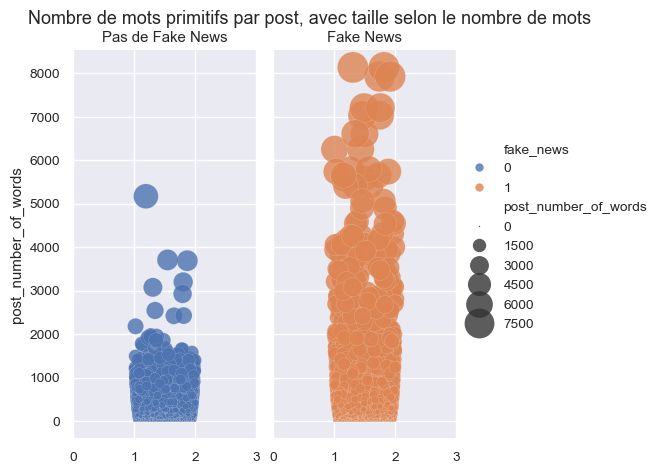

In [78]:
Xrange = np.random.uniform(1, 2, 102661)

g = sns.relplot(data=df, 
                kind='scatter',
                x=Xrange, # x aléatoire dans un range de 1 à 2 pour créer un stripplot fait maison.
                y= 'post_number_of_words',
                size = 'post_number_of_words', 
                sizes = (1,500), 
                alpha = 0.8, 
                hue = 'fake_news', 
                col = 'fake_news',
                height = 5,
                aspect = 0.5)
plt.xlim(0,3)
titles = ['Pas de Fake News', 'Fake News']  # pour chaque subplot
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
plt.subplots_adjust(top=0.9)
plt.suptitle('Nombre de mots primitifs par post, avec taille selon le nombre de mots');

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102661 entries, 0 to 102660
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   record                102661 non-null  int64 
 1   record_copy           102661 non-null  int64 
 2   post                  102661 non-null  object
 3   fake_news             102661 non-null  int64 
 4   post_length           102661 non-null  int64 
 5   post_number_of_words  102661 non-null  int64 
 6   record_test           102661 non-null  int64 
 7   length_record         102661 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.3+ MB


In [82]:
# Affichage de la répartition des post taggé misinformation en fonction de l'indice original
fig = go.Figure()
fig = px.histogram(df,x='record',color="fake_news")
fig.show()
fig.write_image("../reports/figures/misinformation_by_id.jpg",format="jpg")

# Length boxplot
fig = go.Figure(data=go.Box(y=df['post_length'], boxpoints='all', jitter=0.3, pointpos=-1.8))
fig.update_layout(
    title='Répartition des longueurs de post (Boxplot)',
    yaxis_title='Longueur du post'
)
fig.show()

In [83]:
# On constate que la plupart des post font moins de 5000 charactères, on calcule la limite haute
# quartiles Q1 and Q3 calculation
Q1 = df['post_length'].quantile(0.25)
Q3 = df['post_length'].quantile(0.75)
# Calcul de l'écart interquartile (IQR)
IQR = Q3 - Q1
# Calcul de l'Upper Fence (UF)
UF = Q3 + 1.5 * IQR
print(f"Upper Fence (UF): {UF}")

# Violin plot length repartition
traces = []
for misinfo, group in df.groupby('fake_news'):
    trace = go.Violin(y=group['post_length'],
                      name=f"Misinformation: {misinfo}",
                      box_visible=True,
                      line_color='black',
                      meanline_visible=True,
                      fillcolor='lightblue',
                      opacity=0.6,
                      hoverinfo='y')
    traces.append(trace)
fig = go.Figure(data=traces)
fig.update_layout(
    title='Répartition des longueurs de post (Violin Plot)',
    yaxis_title='Longueur du post'
)
fig.update_yaxes(range=[0, UF])
fig.show()

Upper Fence (UF): 4735.5
